### Libraries

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder , StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Called Dataset

In [2]:
# Get the current working directory
directorio_actual = os.getcwd()

# Specify the relative path from the current directory
ruta_csv_relativa = os.path.join('..', 'data', '02_intermediate','2.spotifySinOutlier.csv')

# Load the CSV file
spotify = pd.read_csv(ruta_csv_relativa)

# Show the first rows of the DataFrame
spotify.head(10)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,log_popularity,log_duration_ms
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73.0,230666.0,False,0.676,0.4610,...,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,4.304065,12.348730
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55.0,149610.0,False,0.420,0.1660,...,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,4.025352,11.915794
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57.0,210826.0,False,0.438,0.3590,...,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,4.060443,12.258793
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71.0,201933.0,False,0.266,0.0596,...,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,4.276666,12.215696
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82.0,198853.0,False,0.618,0.4430,...,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,4.418841,12.200326
5,5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58.0,214240.0,False,0.688,0.4810,...,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic,4.077537,12.274857
6,6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74.0,229400.0,False,0.407,0.1470,...,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic,4.317488,12.343227
7,7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80.0,242946.0,False,0.703,0.4440,...,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic,4.394449,12.400599
8,8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74.0,189613.0,False,0.625,0.4140,...,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic,4.317488,12.152746
9,9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56.0,205594.0,False,0.442,0.6320,...,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic,4.043051,12.233663


## Data scaling

This scaling of variables is to be able to work with the models in the future.

### duration_ms Scaler

In [3]:
# Create a StandardScaler object
scaler = MinMaxScaler()

# Select only the popularity column to scale
spotify['duration_ms_scaled'] = scaler.fit_transform(spotify[['log_duration_ms']])

# Show first rows to check
spotify[['duration_ms', 'duration_ms_scaled']].head()

,duration_ms,duration_ms_scaled
0,230666.0,0.461947
1,149610.0,0.387347
2,210826.0,0.446450
3,201933.0,0.439024
4,198853.0,0.436375


### population Scaler

In [4]:
# Create a StandardScaler object
scaler = MinMaxScaler()

# Select only the popularity column to scale
spotify['popularity_scaled'] = scaler.fit_transform(spotify[['log_popularity']])

# Show first rows to check
spotify[['popularity', 'popularity_scaled']].head()

,popularity,popularity_scaled
0,73.0,0.920689
1,55.0,0.849624
2,57.0,0.858572
3,71.0,0.913703
4,82.0,0.949954


### Group feature Scaler

In [5]:
# Select numeric features to scale
features_to_scale = ['danceability', 'energy', 'loudness', 'speechiness', 
                     'acousticness', 'instrumentalness', 'liveness', 
                     'valence', 'tempo']

scaler = MinMaxScaler()
spotify[features_to_scale] = scaler.fit_transform(spotify[features_to_scale])

print('Caracteristicas escaladas: ', features_to_scale)

Caracteristicas escaladas:  ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


## Creating new features

### duration_ms a tiempo_ms_seconds

The duration_ms was calculated so that the millisecond values are converted to minutes and seconds

In [6]:
# Convert milliseconds to seconds
spotify['tiempo_ms_seconds'] = spotify['duration_ms'] / 1000

# Function to convert seconds to minutes and seconds format
def segundos_a_formato(segundos):
    minutos = int(segundos // 60)
    segundos_restantes = int(segundos % 60)
    return f"{minutos} minuto{'s' if minutos != 1 else ''} con {segundos_restantes} segundo{'s' if segundos_restantes != 1 else ''}"

# Apply the function to the seconds column
spotify['duration_ms_scaled'] = spotify['tiempo_ms_seconds'].apply(segundos_a_formato)

# Show the first 10 formatted values
print(spotify['duration_ms_scaled'].head(10))

0    3 minutos con 50 segundos
1    2 minutos con 29 segundos
2    3 minutos con 30 segundos
3    3 minutos con 21 segundos
4    3 minutos con 18 segundos
5    3 minutos con 34 segundos
6    3 minutos con 49 segundos
7     4 minutos con 2 segundos
8     3 minutos con 9 segundos
9    3 minutos con 25 segundos
Name: duration_ms_scaled, dtype: object


### tranck_genre a Label Encoding

Change the categorical label of track_genre to a numeric value.

In [7]:
# Create the tag encoder
le = LabelEncoder()

# Apply Label Encoding to 'track_genre' column
spotify['track_genre_encoded'] = le.fit_transform(spotify['track_genre'])

# View the first rows to verify the encoding
spotify[['track_genre', 'track_genre_encoded']].head()

,track_genre,track_genre_encoded
0,acoustic,0
1,acoustic,0
2,acoustic,0
3,acoustic,0
4,acoustic,0


### New variable "Intensity"

Having a good correlation thanks to the matrix, we decided to choose to combine energy with danceability

In [8]:
# Create a new "intensity" column
spotify['intensity'] = spotify['energy'] * spotify['danceability']
spotify['intensity'].head(10)

0    0.308429
1    0.065544
2    0.148678
3    0.013700
4    0.268868
5    0.327992
6    0.055994
7    0.309893
8    0.254370
9    0.264453
Name: intensity, dtype: float64

#Target Exploration

C:\Users\diego\OneDrive\Imágenes\Escritorio\Spotify-Recomendation-Machine-Learning\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\diego\OneDrive\Imágenes\Escritorio\Spotify-Recomendation-Machine-Learning\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\diego\OneDrive\Imágenes\Escritorio\Spotify-Recomendation-Machine-Learning\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


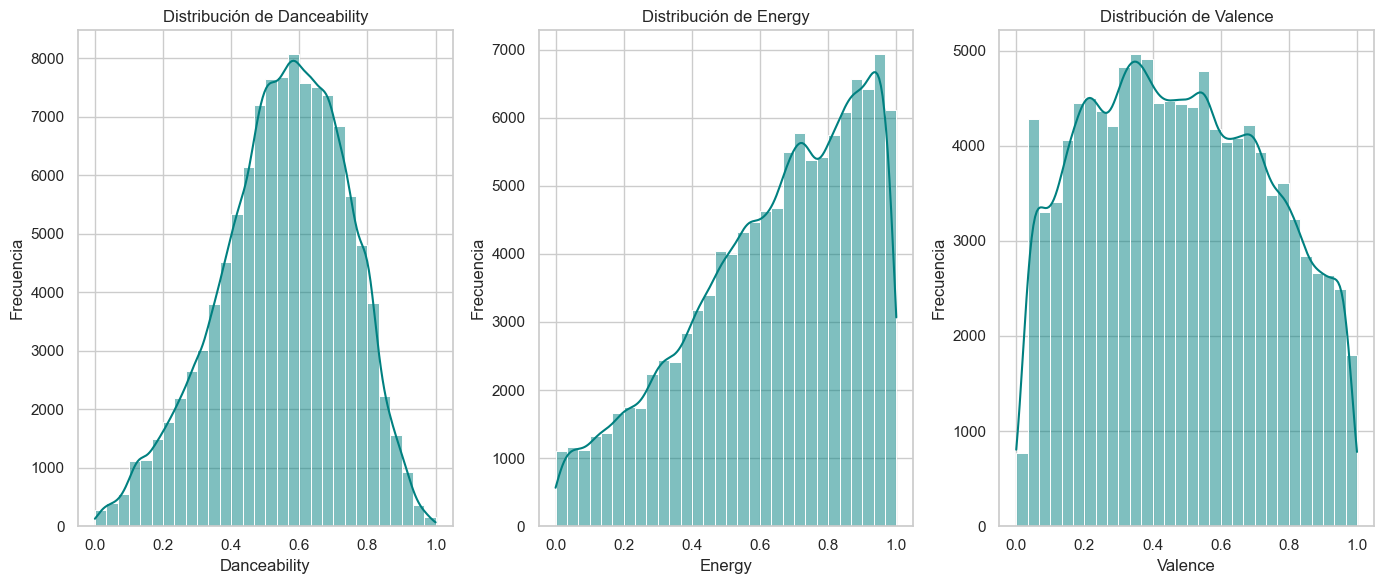

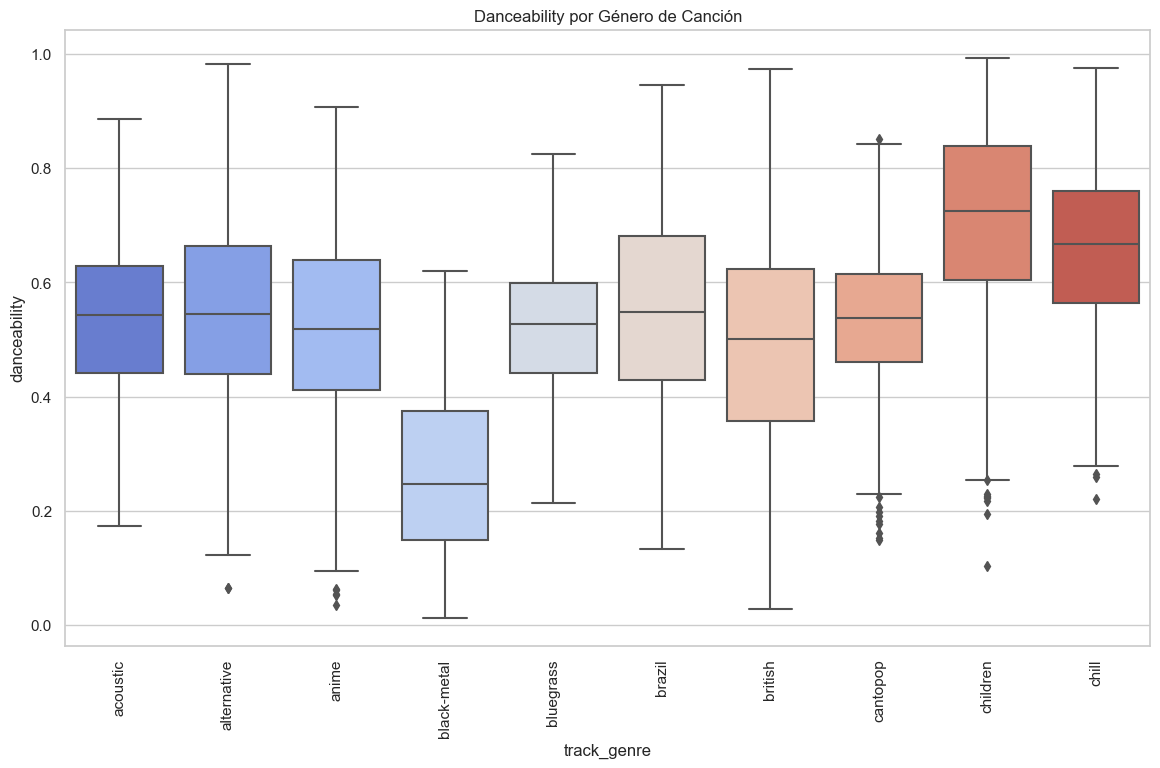

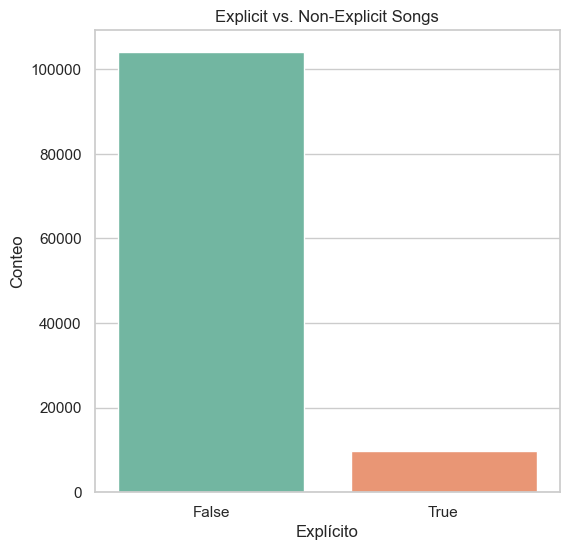

In [9]:
# Replace infinite values with NaN throughout the DataFrame
spotify.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
# Set graphics style
sns.set(style="whitegrid")
#1. Distribution of characteristics that affect recommendations (danceability, energy, valence)
plt.figure(figsize=(14,6))
# Subplots for each feature
for i, feature in enumerate(['danceability', 'energy', 'valence'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(spotify[feature].dropna(), bins=30, kde=True, color='teal')
    plt.title(f'Distribución de {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()
# 2. Relationship between Gender and characteristics for recommendations
plt.figure(figsize=(14,8))
top_genres = spotify['track_genre'].value_counts().nlargest(10) #Top 10 genres
sns.boxplot(x='track_genre', y='danceability', data=spotify[spotify['track_genre'].isin(top_genres.index)].dropna(), palette='coolwarm')
plt.title('Danceability por Género de Canción')
plt.xticks(rotation=90)
plt.show()
#3. Explicit Song Count
plt.figure(figsize=(6,6))
sns.countplot(x='explicit', data=spotify, palette='Set2')
plt.title('Explicit vs. Non-Explicit Songs')
plt.xlabel('Explícito')
plt.ylabel('Conteo')
plt.show()

### Histogram Chart Explanation
Danceability Distribution: The image represents a bell shape, meaning that most songs are danceable, suggesting that it does not greatly affect this field when recommending songs for the user who varies in tastes. Energy Distribution: The graph represents it with values skewed to the right side, meaning that the vast majority of songs have high energy, meaning that if a user opts for 'x' song, it is most likely that the recommendation should be with similar or equal energy levels. Valence Distribution: A uniform distribution,
suggesting that the mix of songs has a high and low positivity, but where the concentration of these values is in the middle of the graph. In summary, the feeling or atmosphere of the songs is mostly related to these three fields where the variability of the values is almost zero, allowing the
song search for the user to be successful most of the time, because no distribution graphs with atypical values were found, but rather, their results are generally close and therefore, successful. Danceability boxplot by song genre: The following graph shows the
relationships of the music genres, where it is highlighted that each box shows the distribution of the Danceability field by music genre. As can be seen, genres such as 'Alt-Rock' and 'Afrobeat' have more danceable songs than genres such as 'ambient' or 'blues'. This helps us to recommend music genres
for the user based on their favorite songs, in this way we have the closest and the most distant genres. Number of songs with explicit and non-explicit lyrics: As you can see, the number of non-explicit songs is around 100,000 songs, compared to songs that do contain explicit lyrics, where the value is around 8,000 to 10,000 songs. This option is crucial for song recommendations, since if the user chooses songs with explicit lyrics, the number of recommendations drops drastically compared to choosing songs without explicit lyrics, although it also gives the option to choose from both options. This is accompanied by business question 3, which shows us the exact number of songs with explicit lyrics by music genre. Conclusion: The graphs shown give us a broad resolution that covers themes of atmosphere or feelings that the songs deliver, similarity between music genres based on their danceability, and the number of songs with and without explicit lyrics. This will allow us to define in a more exact way the recommendations that we give to the user based on their tastes.

In [10]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113799 entries, 0 to 113798
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           113799 non-null  int64  
 1   track_id             113799 non-null  object 
 2   artists              113798 non-null  object 
 3   album_name           113798 non-null  object 
 4   track_name           113798 non-null  object 
 5   popularity           113799 non-null  float64
 6   duration_ms          113799 non-null  float64
 7   explicit             113799 non-null  bool   
 8   danceability         113799 non-null  float64
 9   energy               113799 non-null  float64
 10  key                  113799 non-null  int64  
 11  loudness             113799 non-null  float64
 12  mode                 113799 non-null  int64  
 13  speechiness          113799 non-null  float64
 14  acousticness         113799 non-null  float64
 15  instrumentalness 

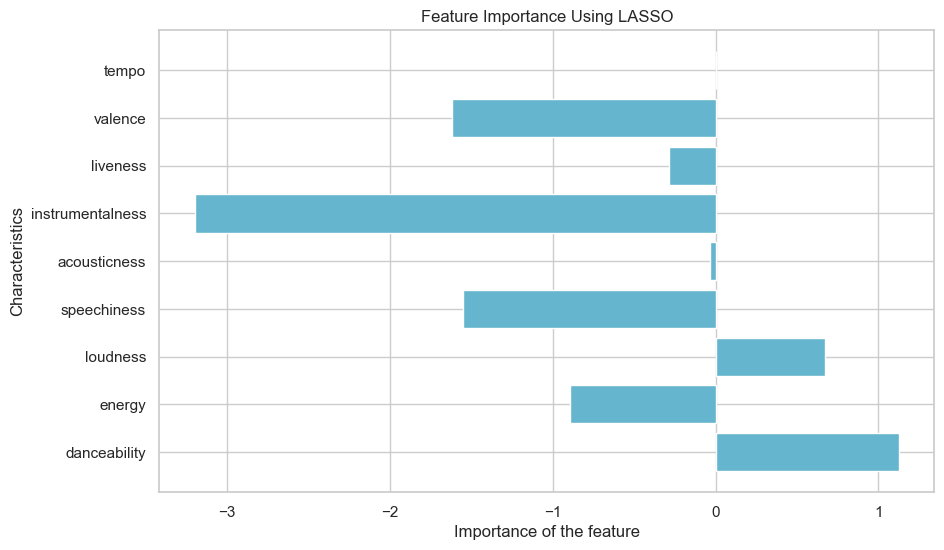

In [11]:
# We select the numerical features that we want to use for the regression
X = spotify[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
             'instrumentalness', 'liveness', 'valence', 'tempo']]  # Adjusts according to the available numeric columns

# Target column
y = spotify['popularity']

# Standardize the characteristics
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the LASSO model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Get the coefficients (feature importance)
importancia = lasso.coef_

# Create a bar chart
caracteristicas = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                   'instrumentalness', 'liveness', 'valence', 'tempo']  # Your number columns
plt.figure(figsize=(10, 6))
plt.barh(caracteristicas, importancia, color='c')
plt.xlabel("Importance of the feature")
plt.ylabel("Characteristics")
plt.title("Feature Importance Using LASSO")
plt.show()

## Explanation
As you can see, using the LASSO method you can determine which are the most important variables of the Dataset (Target). As an observation, you can see the following:

1) The fields 'loudness' and 'danceability' have positive importance compared to the other fields, but in the case of 'loudness' its influence is less compared to the 'danceability' field.
2) Fields such as 'valance', 'liveness', 'instrumentalness', 'acousticness', 'speechiness' and 'energy' have negative importance, which means that for the search of the target field 'popularity', its influence is negative but noticeable.

Conclusion:

As an assessment, we can highlight 3 variables that influence the prediction of song popularity. Fields such as 'danceability' and 'loudness' have a minor but positive influence. On the other hand, the field that has the most influence is 'instrumentalness', which, being of negative impact, the higher the value of this characteristic, the worse its influence when predicting the target field. Therefore, it has been decided that these 3 fields are the most suitable for prediction, since they produce a greater influence compared to the other fields.

# Feature Removal

Se elimino. 
- Unnamed : 0
- artists
- album_name
- track_id
- track_name
- explicit 
- time_signature
- mode

In [12]:
# List of columns you want to delete
columnas_a_eliminar = ['Unnamed: 0', 'artists', 'album_name', 'track_id', 'track_name', 
                       'explicit', 'time_signature', 'mode']

# Remove columns from the DataFrame
spotify = spotify.drop(columns=columnas_a_eliminar)

# Verificar las primeras filas para confirmar que las columnas fueron eliminadas
spotify.head()


,popularity,duration_ms,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,log_popularity,log_duration_ms,duration_ms_scaled,popularity_scaled,tiempo_ms_seconds,track_genre_encoded,intensity
0,73.0,230666.0,0.669059,0.460989,1,0.779395,0.128221,0.032329,0.000001,0.352006,0.718593,0.301970,acoustic,4.304065,12.348730,3 minutos con 50 segundos,0.920689,230.666,0,0.308429
1,55.0,149610.0,0.394881,0.165983,1,0.574223,0.057482,0.927711,0.000006,0.092607,0.268342,0.243282,acoustic,4.025352,11.915794,2 minutos con 29 segundos,0.849624,149.610,0,0.065544
2,57.0,210826.0,0.414159,0.358987,0,0.720948,0.035635,0.210843,0.000000,0.108756,0.120603,0.236770,acoustic,4.060443,12.258793,3 minutos con 30 segundos,0.858572,210.826,0,0.148678
3,71.0,201933.0,0.229945,0.059581,0,0.549185,0.015060,0.908635,0.000071,0.123896,0.143719,0.830006,acoustic,4.276666,12.215696,3 minutos con 21 segundos,0.913703,201.933,0,0.013700
4,82.0,198853.0,0.606940,0.442989,2,0.721984,0.032347,0.470884,0.000000,0.074338,0.167839,0.482246,acoustic,4.418841,12.200326,3 minutos con 18 segundos,0.949954,198.853,0,0.268868


## Exploración nuevo DataSet "spotify"

## Correlation Matrix

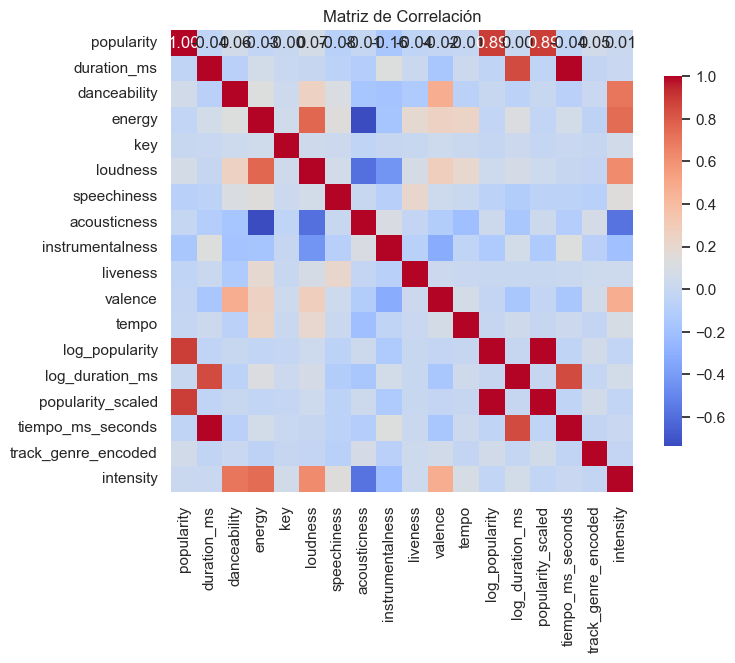

In [13]:
# Selección de Datos Numéricos
datosNumericos = spotify.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
matriz_correlacion = datosNumericos.corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': .8})
plt.title('Matriz de Correlación')
plt.show()

## Información del DataSet

In [14]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113799 entries, 0 to 113798
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   popularity           113799 non-null  float64
 1   duration_ms          113799 non-null  float64
 2   danceability         113799 non-null  float64
 3   energy               113799 non-null  float64
 4   key                  113799 non-null  int64  
 5   loudness             113799 non-null  float64
 6   speechiness          113799 non-null  float64
 7   acousticness         113799 non-null  float64
 8   instrumentalness     113799 non-null  float64
 9   liveness             113799 non-null  float64
 10  valence              113799 non-null  float64
 11  tempo                113799 non-null  float64
 12  track_genre          113799 non-null  object 
 13  log_popularity       113799 non-null  float64
 14  log_duration_ms      113799 non-null  float64
 15  duration_ms_scale

## Cantidad total de datos

In [15]:
spotify.dtypes.value_counts()

float64    16
int64       2
object      2
Name: count, dtype: int64

# Futuro

El objetivo de este proyecto es desarrrollar un sistema de recomendación de música. Utilizando como target popularity y ademas se usara K-Means y K-Vecinos más cercanos (K-NN). Hemos utilizado el procedimiento previo para preparar el conjunto de datos. 
- Escalado de variables: La mayoría de las variables numéricas han sido escaladas. Para asegurar que todas las características sean similares.
- Eliminación de variables categóricas: Las variables categóricas se han eliminado o transformado con el método de Label Encoding, para evitar problemas con los algoritmos que no puedan procesar ese tipo de dato.

El sistema de recomendación funcionará agrupando canciones similares (K-Means) o sugiriendo canciones basadas a las características (K-NN). De esta forma se busca que el sistema pueda recomendar canciones que se alineen con el gusto del usuario.
Cabe recalcar que el método para lograr el objetivo puede cambiar al avanzar con el desarrollo y evaluación de los modelos. Nuestra intención es buscar el mejor modelo para nuestro Recomendador. 

# Save DataSet

In [16]:
rute_cvs_save = os.path.join('..','data','03_primary','3.spotify.csv')
                             
spotify.to_csv (rute_cvs_save, index=False)

C:\Users\diego\OneDrive\Imágenes\Escritorio\Spotify-Recomendation-Machine-Learning\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\diego\OneDrive\Imágenes\Escritorio\Spotify-Recomendation-Machine-Learning\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\diego\OneDrive\Imágenes\Escritorio\Spotify-Recomendation-Machine-Learning\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


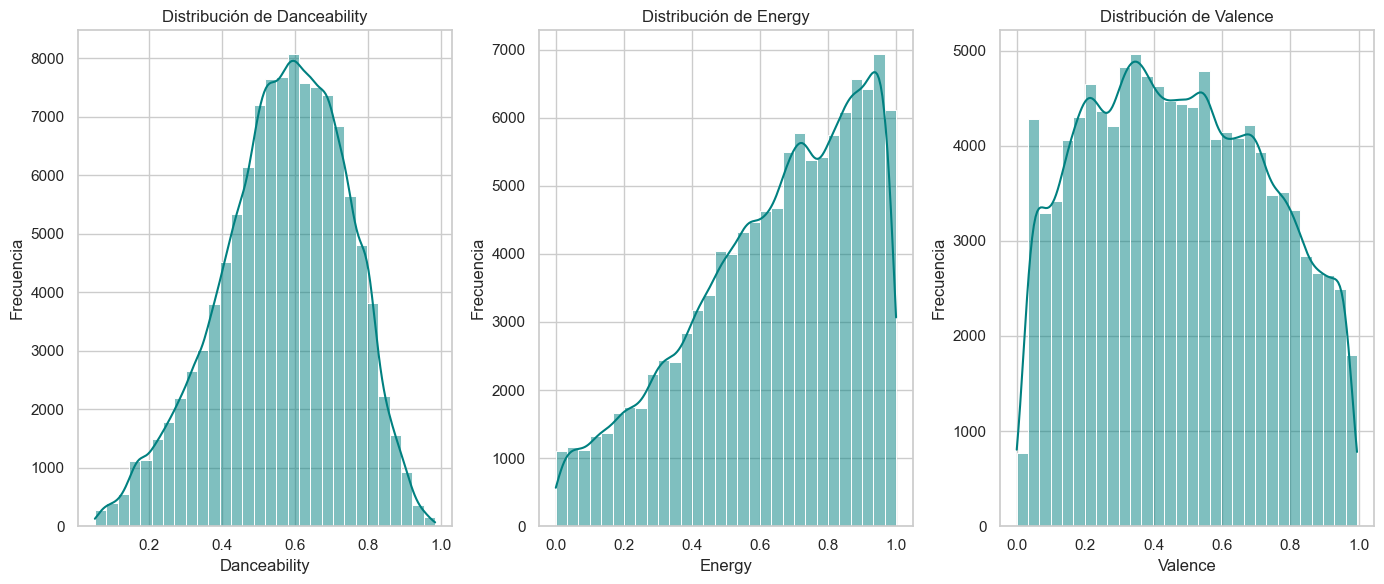

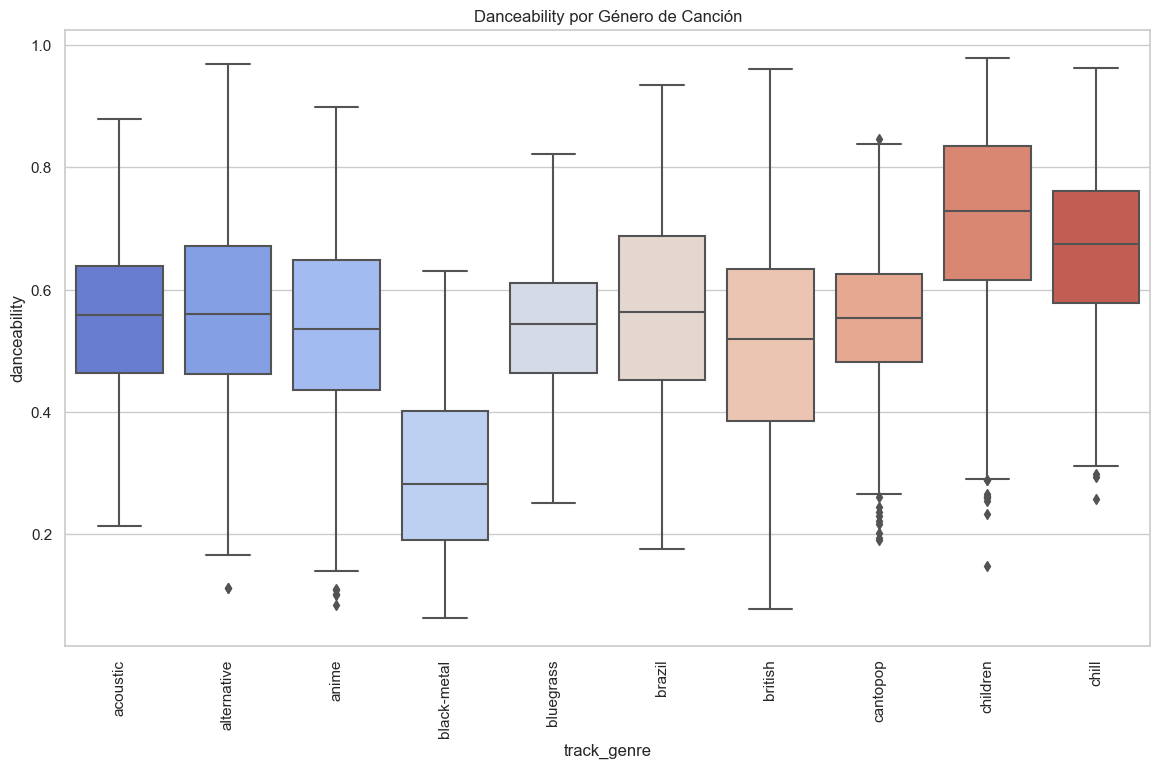

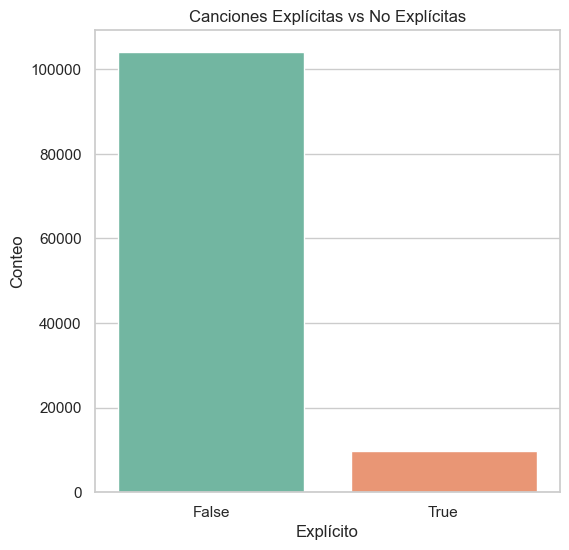

In [17]:
# Cargar el archivo CSV
spotify = pd.read_csv(ruta_csv_relativa)
# Reemplazar valores infinitos por NaN en todo el DataFrame
spotify.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
# Configurar estilo de gráficos
sns.set(style="whitegrid")
# 1. Distribución de las características que afectan recomendaciones (danceability, energy, valence)
plt.figure(figsize=(14,6))
# Subplots para cada característica
for i, feature in enumerate(['danceability', 'energy', 'valence'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(spotify[feature].dropna(), bins=30, kde=True, color='teal')
    plt.title(f'Distribución de {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()
# 2. Relación entre Género y las características para recomendaciones
plt.figure(figsize=(14,8))
top_genres = spotify['track_genre'].value_counts().nlargest(10)  # Top 10 géneros
sns.boxplot(x='track_genre', y='danceability', data=spotify[spotify['track_genre'].isin(top_genres.index)].dropna(), palette='coolwarm')
plt.title('Danceability por Género de Canción')
plt.xticks(rotation=90)
plt.show()
# 3. Conteo de canciones explícitas
plt.figure(figsize=(6,6))
sns.countplot(x='explicit', data=spotify, palette='Set2')
plt.title('Canciones Explícitas vs No Explícitas')
plt.xlabel('Explícito')
plt.ylabel('Conteo')
plt.show()